In [91]:
import numpy as np
import yfinance as yf
import pandas as pd
from numpy.typing import NDArray
from scipy.optimize import minimize
from tqdm import trange
import matplotlib.pyplot as plt

def portfolio_var(
        weigths: NDArray[np.float64], 
        sigma: NDArray[np.float64]
    ) -> np.float64:
    '''Function for calculating portfolio variance
    Args:
        weights (NDArray): numpy array with portfolio weights
        sigma (NDArray): covariance matrix
    Returns:
        portfolio_variance (float): portfolio variance
    '''
    portfolio_variance = weigths.T @ sigma @ weigths

    return portfolio_variance

def portfolio_sharpe(
        weigths: NDArray[np.float64], 
        sigma: NDArray[np.float64],
        mu: NDArray[np.float64]
    ) -> np.float64:

    '''Function for calculating portfolio sharpe ratio
    Args:
        weights (NDArray): numpy array with portfolio weights
        sigma (NDArray): covariance matrix
        mu: mean returns
    Returns:
        portfolio_sharpe (float): portfolio sharpe ratio
    '''
    portfolio_sharpe = -np.mean(weigths * mu) / np.sqrt(portfolio_var(weigths, sigma))

    return portfolio_sharpe


def find_OW(
        function, 
        *args: NDArray[np.float64], 
        n: int = 1
    ) -> NDArray[np.float64]:
    
    '''Function for calculating portfolio optimal weights
    Args:
        function (func): objective function to be minimized
        *args (NDArray): objective function arguments
        n (int): number of weights

    Returns:
        OW (NDArray): numpy array with optimal portfolio weights
    '''
    res = minimize(
        function, 
        x0=np.ones(n) / n, 
        method='SLSQP', 
        bounds=tuple((0,1) for x in range(n)), 
        constraints = {'type': 'eq', 'fun': lambda x:  1 - sum(x)},
        args=args,
    )
    OW = res.x

    return OW


100%|██████████| 252/252 [00:03<00:00, 66.21it/s]


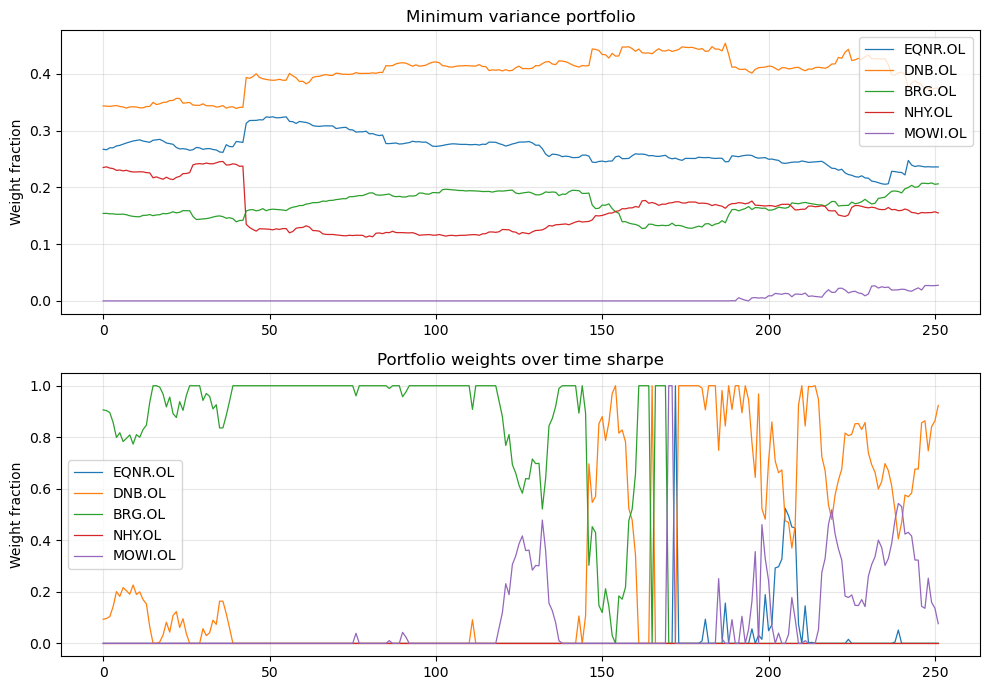

In [92]:


tickers: list[str] = ['EQNR.OL', 'DNB.OL', 'BRG.OL', 'NHY.OL', 'MOWI.OL']
tic_names: list[str] = ['Equinor ASA', 'DNB ASA', 'Aker Solutions ASA', 'Norsk Hydro ASA']

n = len(tickers)

closing_price = yf.download(
    tickers, 
    period='5Y', 
    ignore_tz=True, 
    progress=False
)['Adj Close']

log_returns = np.log(closing_price/closing_price.shift()).dropna()

mean_returns = np.array(log_returns.mean()) 
cov_matrix = np.array(log_returns.cov())

days = 252

res_matrix_min = np.zeros((days, len(tickers)))
res_matrix_sharpe = np.zeros((days, len(tickers)))

rolling_mean = log_returns.rolling(days).sum().iloc[-days:]

for i in trange(days):

    mean_returns = rolling_mean.iloc[i] * 252

    cov_matrix = log_returns.iloc[-2*days + i:-days+i].cov().to_numpy() * 252 

    OW_min = find_OW(portfolio_var, cov_matrix, n=n)
    res_matrix_min[i, :] = OW_min

    OW_sharpe = find_OW(portfolio_sharpe, cov_matrix, mean_returns, n=n)
    res_matrix_sharpe[i, :] = OW_sharpe

results_min = pd.DataFrame(res_matrix_min, columns=tickers)
results_sharpe = pd.DataFrame(res_matrix_sharpe, columns=tickers)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

results_min.plot(ax=ax1, linewidth=0.9)

ax1.set_title('Minimum variance portfolio')
ax1.set_ylabel('Weight fraction')
ax1.grid(alpha=0.3)

results_sharpe.plot(ax=ax2, linewidth=0.9)

ax2.set_title('Portfolio weights over time sharpe')
ax2.set_ylabel('Weight fraction')
ax2.grid(alpha=0.3)

fig.tight_layout()